In [1]:
pip install mahotas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 20.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import mahotas as mh
from skimage import io, color
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

def extract_glcm_features(image):
    """ Extract GLCM features from an image converted to grayscale and scaled to 8-bit. """
    try:
        gray_image = color.rgb2gray(image)
        gray_image = (gray_image * 255).astype(np.uint8)
        features = mh.features.haralick(gray_image).mean(0)
        return features
    except Exception as e:
        print(f"Error processing image with GLCM: {e}")
        return np.zeros(13)  # Return an array of zeros if there's an error

def process_image(file_path):
    """ Load an image and extract features. """
    try:
        image = io.imread(file_path, as_gray=False)
        if image.size == 0:
            raise ValueError("Image is empty.")
        return extract_glcm_features(image)
    except Exception as e:
        print(f"Failed to process image {file_path}: {e}")
        return None

def process_case(case_path):
    """ Process each image in a case folder. """
    features_list = []
    for filename in os.listdir(case_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(case_path, filename)
            features = process_image(image_path)
            if features is not None:
                features_list.append(features)
    return features_list

def process_directory(directory_path):
    """ Walk through the directory and process each image in each case in each class folder. """
    data = []
    labels = []
    for class_folder in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_folder)
        if os.path.isdir(class_path):
            for case_folder in os.listdir(class_path):
                case_path = os.path.join(class_path, case_folder)
                if os.path.isdir(case_path):
                    print(f"Processing {case_folder} in {class_folder}")
                    # Parallel processing for each case
                    with ThreadPoolExecutor() as executor:
                        futures = [executor.submit(process_image, os.path.join(case_path, f))
                                   for f in os.listdir(case_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
                        for future in as_completed(futures):
                            result = future.result()
                            if result is not None:
                                data.append(result)
                                labels.append(class_folder)

    return data, labels

# Define the path to the dataset
dataset_path = '/kaggle/input/dataset-a4c-all/Dataset_A4C'

# Extract features
features_data, labels = process_directory(dataset_path)

# Define GLCM feature names
glcm_feature_names = ['Energy', 'Contrast', 'Correlation', 'Variance', 'Inverse Difference Moment',
                      'Sum Average', 'Sum Variance', 'Sum Entropy', 'Entropy', 'Difference Variance',
                      'Difference Entropy', 'Information Measure of Correlation I', 'Information Measure of Correlation II']

# Create DataFrame and save to CSV
df = pd.DataFrame(features_data, columns=glcm_feature_names)
df['Label'] = labels
df.to_csv('complete_glcm_features_a4c.csv', index=False)

Processing III_TrainVal (646) in III
Processing III_TrainVal (295) in III
Processing III_TrainVal (262) in III
Processing III_TrainVal (163) in III
Processing III_TrainVal (297) in III
Processing III_TrainVal (587) in III
Processing III_TrainVal (442) in III
Processing III_TrainVal (451) in III
Processing III_TrainVal (719) in III
Processing III_TrainVal (334) in III
Processing III_TrainVal (563) in III
Processing III_TrainVal (309) in III
Processing III_TrainVal (80) in III
Processing III_TrainVal (537) in III
Processing III_Test (80) in III
Processing III_TrainVal (87) in III
Processing III_TrainVal (358) in III
Processing III_TrainVal (323) in III
Processing III_TrainVal (294) in III
Processing III_TrainVal (204) in III
Processing III_TrainVal (139) in III
Processing III_TrainVal (456) in III
Processing III_TrainVal (260) in III
Processing III_TrainVal (372) in III
Processing III_TrainVal (115) in III
Processing III_TrainVal (623) in III
Processing III_TrainVal (448) in III
Processi

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [5]:
# Load the features and labels from CSV
df = pd.read_csv('/kaggle/input/glcm-a4c/complete_glcm_features_a4c.csv')

# Separate features and labels
X = df.drop('Label', axis=1)
y = df['Label']

In [6]:
# Handle missing values if there are any
X.fillna(X.mean(), inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [12]:
# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 84.87%
Classification Report:
              precision    recall  f1-score   support

         III       0.83      0.93      0.88      6406
          MS       0.88      0.77      0.82      3285
          NL       0.86      0.77      0.82      3292

    accuracy                           0.85     12983
   macro avg       0.86      0.82      0.84     12983
weighted avg       0.85      0.85      0.85     12983



Confusion Matrix:
[[5948  211  247]
 [ 608 2526  151]
 [ 627  120 2545]]


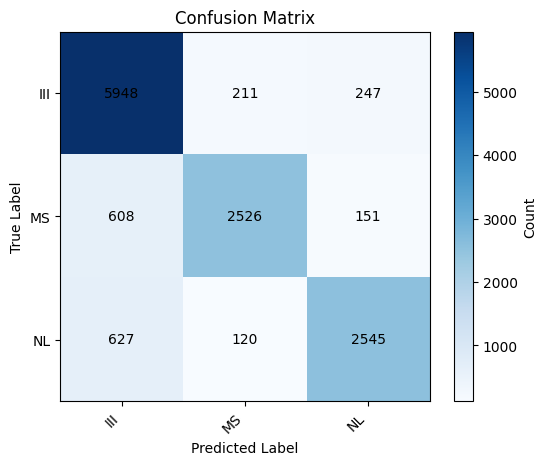

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a function to plot the confusion matrix (optional)
def plot_confusion_matrix(cm, class_names):
  """
  Plots a confusion matrix with labels.
  """
  fig, ax = plt.subplots()
  im = ax.imshow(cm, cmap=plt.cm.Blues)
  ax.grid(False)
  for i in range(len(class_names)):
    for j in range(len(class_names)):
      ax.text(j, i, cm[i, j], ha='center', va='center', color="black")
  ax.set_ylabel("True Label")
  ax.set_xlabel("Predicted Label")
  ax.set_title("Confusion Matrix")
  ax.set_xticks(np.arange(len(class_names)))
  ax.set_yticks(np.arange(len(class_names)))
  ax.set_xticklabels(class_names, rotation=45, ha='right')
  ax.set_yticklabels(class_names)
  plt.colorbar(im, label='Count')
  plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix (optional)
class_names = ["III", "MS", "NL"]  # Assuming these are your class labels
plot_confusion_matrix(cm, class_names)